In [1]:
import json
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import dns.resolver

RESULTS_PATH = pathlib.Path("results.jsonl")
BLOCKLIST_PATH = pathlib.Path("services.json")
ENTITIES_PATH = pathlib.Path("entities.json")


def load_results(path: pathlib.Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    visits, requests = [], []
    with path.open("r", encoding="utf-8") as handle:
        for line in handle:
            record = json.loads(line)
            visits.append(
                {
                    "visit_id": record["visit_id"],
                    "crawl_mode": record.get("crawl_mode"),
                    "consent_action": record.get("consent_action"),
                    "country": record.get("country"),
                    **record.get("summary", {}),
                }
            )
            for req in record.get("requests", []):
                requests.append(
                    {
                        "visit_id": record["visit_id"],
                        "crawl_mode": record.get("crawl_mode"),
                        "url": req.get("url"),
                        "status": req.get("status"),
                        "is_third_party": req.get("is_third_party"),
                        "disconnect_category": req.get("disconnect_category"),
                        "resourceType": req.get("resourceType"),
                        "blocked": req.get("blocked"),
                        "time": req.get("time"),
                        "ipAddress": req.get("ipAddress"),
                        "response_headers": req.get("response_headers"),
                        "redirect_url": req.get("redirectURL"),
                    }
                )
    return pd.DataFrame(visits), pd.DataFrame(requests)

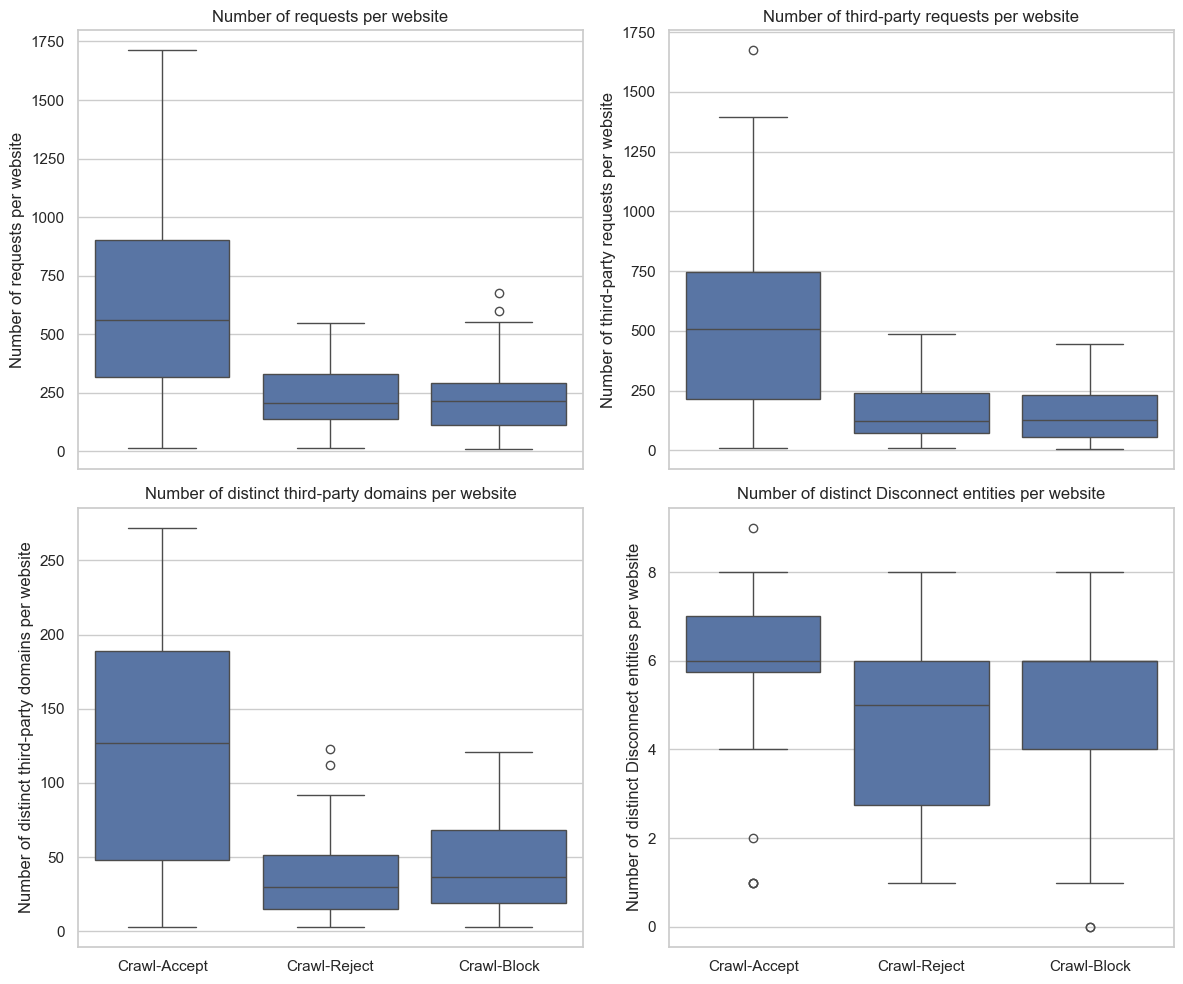

In [2]:
# 1: Compare crawl sessions using distributions of key tracking metrics

visits_df, _ = load_results(RESULTS_PATH)

label_map = {"accept": "Crawl-Accept", "reject": "Crawl-Reject", "block": "Crawl-Block"}
visits_df = visits_df.assign(
    crawl_label=visits_df["crawl_mode"].map(label_map),
    distinct_entities=visits_df["disconnect_category_counts"].apply(
        lambda d: len(d) if isinstance(d, dict) else 0
    ),
)

metrics = [
    ("total_requests", "Number of requests per website"),
    ("third_party_requests", "Number of third-party requests per website"),
    ("unique_domains_third_party", "Number of distinct third-party domains per website"),
    ("distinct_entities", "Number of distinct Disconnect entities per website"),
]

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

for ax, (col, title) in zip(axes.flat, metrics):
    if col not in visits_df:
        raise KeyError(f"Missing summary column: {col}")
    sns.boxplot(
        data=visits_df,
        x="crawl_label",
        y=col,
        order=["Crawl-Accept", "Crawl-Reject", "Crawl-Block"],
        ax=ax,
    )
    ax.set_xlabel("")
    ax.set_ylabel(title)
    ax.set_title(title)

plt.tight_layout()
plt.show()

The plot compares the three crawl modes (accept, reject, block) across four metrics describing tracking behavior:
- Number of requests per website: Crawl-Accept shows a substantially higher number of requests than the other modes, while Reject and Block produce fewer requests overall.
- Number of Third-party requests per website: accept triggers more third-party requests than Reject or Block. The last two, show lower medians.
- Number of distinct third-party: websites visited under accept contact a much larger and more variable set of third party domains. Reject and Block show lower medians.
- Number of disinct dsconnect entities per website: accept shows highly numbers of distinct entities, but the difference between the three crawls are smaller than in previous metrics. 

In [3]:
# 2: Summary statistics (min, median, max) for visit-level metrics per crawl mode

visits_df, _ = load_results(RESULTS_PATH)

label_map = {"accept": "Crawl-Accept", "reject": "Crawl-Reject", "block": "Crawl-Block"}
visits_df["crawl_label"] = visits_df["crawl_mode"].map(label_map)

visits_df["distinct_entities"] = visits_df["disconnect_category_counts"].apply(
    lambda d: len(d) if isinstance(d, dict) else 0
)

metrics = {
    "total_requests": "Number of requests per website",
    "third_party_requests": "Number of third-party requests per website",
    "unique_domains_third_party": "Number of distinct third-party domains per website",
    "distinct_entities": "Number of distinct Disconnect entities per website",
}

stats = ["min", "median", "max"]

summary = (
    visits_df.groupby("crawl_label")[list(metrics.keys())]
    .agg(stats) # type: ignore
    .rename_axis(index="Crawl")
)

summary.columns = [f"{metrics[col]} – {stat.title()}" for col, stat in summary.columns]
summary

,Number of requests per website – Min,Number of requests per website – Median,Number of requests per website – Max,Number of third-party requests per website – Min,Number of third-party requests per website – Median,Number of third-party requests per website – Max,Number of distinct third-party domains per website – Min,Number of distinct third-party domains per website – Median,Number of distinct third-party domains per website – Max,Number of distinct Disconnect entities per website – Min,Number of distinct Disconnect entities per website – Median,Number of distinct Disconnect entities per website – Max
Crawl,,,,,,,,,,,,
Crawl-Accept,13,561.5,1712,10,506.0,1674,3,127.0,272,1,6.0,9
Crawl-Block,8,214.5,677,4,128.5,445,3,36.5,121,0,6.0,8
Crawl-Reject,13,208.0,549,10,123.0,487,3,30.0,123,1,5.0,8


The table reports minumim, median, and maximum values for four tracking metrics across the three crawl modes.
- Number of requests per website: Crawl-Accept generates the most traffic, with a median of 561.5 requests and a maximum of 1712, far above Reject (208) and Block (214.5).
- Number of third-party requests per website: under Accept, the median is 506, compared to 123 for Reject and 128.5 for Block. This means that consenting to tracking results in sever hundred additional third-party requests on average. 
- Number of distinct third-party domains per website: website under Accept contact a larger set of external domains, with a median of 127, compared to 30 under Reject and 36.5 for Block.
- Number of distinct disconnect entities per website: here the differences between the crawl modes are smaller: Accept and Block both have a median of 6 entities, while Reject is slightly lower at 5. This means that the set of types of tracking entities involved doesn't change with consent decisions.

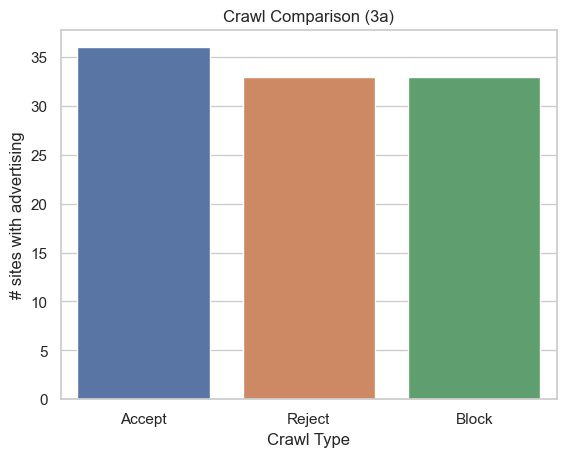

In [4]:
# 3a: Number of sites with at least one Advertising request per crawl mode

visits_df, requests_df = load_results(RESULTS_PATH)

label_map = {"accept": "Accept", "reject": "Reject", "block": "Block"}

# For each (visit_id, crawl_mode), check if there is at least one Advertising request
adv_by_visit_mode = (
    requests_df
    .assign(has_advertising=requests_df["disconnect_category"] == "Advertising")
    .groupby(["visit_id", "crawl_mode"], as_index=False)["has_advertising"]
    .any()
)

visits_with_adv = (
    visits_df
    .merge(adv_by_visit_mode, on=["visit_id", "crawl_mode"], how="left")
)

visits_with_adv["has_advertising"] = visits_with_adv["has_advertising"].fillna(False)
visits_with_adv = visits_with_adv.assign(
    crawl_label=visits_with_adv["crawl_mode"].map(label_map)
)

# Count how many sites per crawl type have Advertising
summary = (
    visits_with_adv
    .groupby("crawl_label")["has_advertising"]
    .sum()
    .reindex(["Accept", "Reject", "Block"])
    .rename("# sites with advertising")
)

# Convert Series into a DataFrame for seaborn
summary_df = (
    summary
    .reset_index()
    .rename(columns={
        "crawl_label": "Crawl Type",
        "# sites with advertising": "Sites with advertising"
    })
)

sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=summary_df,
    x="Crawl Type",
    y="Sites with advertising",
    hue="Crawl Type",
    palette=["#4C72B0", "#DD8452", "#55A868"],
    legend=False,
)

ax.set_xlabel("Crawl Type")
ax.set_ylabel("# sites with advertising")
ax.set_title("Crawl Comparison (3a)")
plt.show()

The bar chart shows how many websites triggered at least one request to a domain categorized as Advertising by Disconnect, for each of the three crawl modes.
- Crawl-Accept shows the highest count with around 36 websites contacting at least one Advertising domain.
- Crawl-Reject results in fewer such websites, around 33.
- Crawl-Block is almost identical to Reject, also around 33.

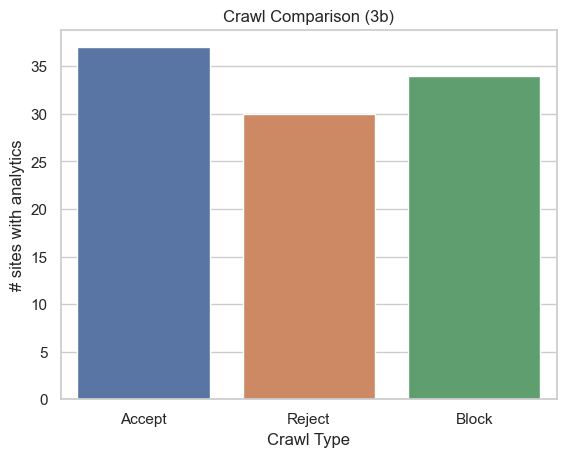

In [5]:
# 3b: Number of sites with at least one Analytics request per crawl mode

visits_df, requests_df = load_results(RESULTS_PATH)

label_map = {"accept": "Accept", "reject": "Reject", "block": "Block"}

# For each (visit_id, crawl_mode), check if there is at least one Analytics request
ana_by_visit_mode = (
    requests_df
    .assign(has_analytics=requests_df["disconnect_category"] == "Analytics")
    .groupby(["visit_id", "crawl_mode"], as_index=False)["has_analytics"]
    .any()
)

visits_with_ana = (
    visits_df
    .merge(ana_by_visit_mode, on=["visit_id", "crawl_mode"], how="left")
)

visits_with_ana["has_analytics"] = visits_with_ana["has_analytics"].fillna(False)
visits_with_ana = visits_with_ana.assign(
    crawl_label=visits_with_ana["crawl_mode"].map(label_map)
)

# Count how many sites per crawl type have Analytics
summary = (
    visits_with_ana
    .groupby("crawl_label")["has_analytics"]
    .sum()
    .reindex(["Accept", "Reject", "Block"])
    .rename("# sites with analytics")
)

# Convert Series into a DataFrame for seaborn
summary_df = (
    summary
    .reset_index()
    .rename(columns={
        "crawl_label": "Crawl Type",
        "# sites with analytics": "Sites with analytics"
    })
)

sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=summary_df,
    x="Crawl Type",
    y="Sites with analytics",
    hue="Crawl Type",
    palette=["#4C72B0", "#DD8452", "#55A868"],
    legend=False,
)

ax.set_xlabel("Crawl Type")
ax.set_ylabel("# sites with analytics")
ax.set_title("Crawl Comparison (3b)")
plt.show()

The chart shows how many websites, in each crawl mode, sent at least one request to a domain categorized as Analytics in Disconnect's blocklist. The distribution across crawl modes is similar:
- Crawl-Accept has the highest number of sites with analytics activity, about 37.
- Crawl-Reject shows around 30 websites, indicating that rejecting cookie banners can somewhat reduce analytics tracking.
- Crawl-Block sits between the two on 34 websites.

In [6]:
# 4: Compare Accept-crawl summary metrics between US and European news sites

visits_all, _ = load_results(RESULTS_PATH)
visits_all = visits_all.assign(
    distinct_entities=visits_all["disconnect_category_counts"].apply(
        lambda d: len(d) if isinstance(d, dict) else 0
    )
)

metrics = {
    "total_requests": "Number of requests per website",
    "third_party_requests": "Number of third-party requests per website",
    "unique_domains_third_party": "Number of distinct third-party domains per website",
    "distinct_entities": "Number of distinct Disconnect entities per website",
}
for col in metrics:
    visits_all[col] = pd.to_numeric(visits_all[col], errors="coerce")

us_countries = {"US"}
eu_countries = {"DE", "FR", "NL", "BE", "ES", "IT", "PT", "SE", "DK", "NO", "FI", "IE", "AT", "CH"}

accept_df = visits_all[visits_all["crawl_mode"] == "accept"].copy()
accept_df["region"] = accept_df["country"].str.upper().map(
    lambda c: "US News Sites" if c in us_countries else ("European News Sites" if c in eu_countries else None)
)

stats = ["min", "median", "max"]
summary_us_eu = (
    accept_df.dropna(subset=["region"])
    .groupby("region")[list(metrics.keys())]
    .agg(stats) # type: ignore
    .rename_axis(index="Metric group")
    .transpose()
)

summary_us_eu.index = [
    f"{metrics[col]} – {stat.title()}" for col, stat in summary_us_eu.index
]
regions = ["US News Sites", "European News Sites"]
summary_us_eu = summary_us_eu.reindex(columns=regions)
summary_us_eu.loc[:, regions]

Metric group,US News Sites,European News Sites
Number of requests per website – Min,13.0,167.0
Number of requests per website – Median,456.0,630.0
Number of requests per website – Max,1376.0,1712.0
Number of third-party requests per website – Min,10.0,123.0
Number of third-party requests per website – Median,377.0,550.0
Number of third-party requests per website – Max,1339.0,1674.0
Number of distinct third-party domains per website – Min,3.0,12.0
Number of distinct third-party domains per website – Median,95.5,159.0
Number of distinct third-party domains per website – Max,269.0,272.0
Number of distinct Disconnect entities per website – Min,1.0,2.0


This analysis compares US and European news websites under the Accept crawl. Overal, European sites show consistently higher tracking acctivity across almost all measures.
- Number of requests per website: European sites generates more request with a median of 630 compared to 456 for the US sites. Maximum values also differ consistently.
- Third-party requests per website: the same patter holds for third-party traffic, with European websites reaching higher median and maximum values.
- Distinct third-party domains per website: European sites also contact a broader range of third-party domain.
- Distinct Disconnect entities per website: this is the only metric where the two regions are similar, both having a median of 6 distinc entities.

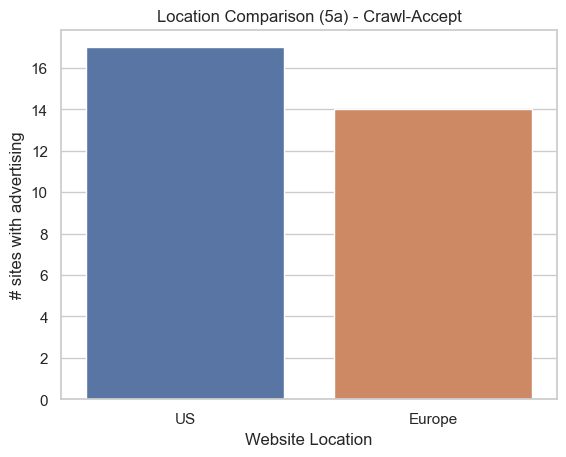

In [7]:
# 5a: Compare US vs European sites with at least one Advertising request in Crawl-Accept

visits_accept, requests_accept = load_results(RESULTS_PATH)
visits_accept = visits_accept.assign(
    distinct_entities=visits_accept["disconnect_category_counts"].apply(
        lambda d: len(d) if isinstance(d, dict) else 0
    )
)

us_countries = {"US"}
eu_countries = {"DE", "FR", "NL", "BE", "ES", "IT", "PT", "SE", "DK", "NO", "FI", "IE", "AT", "CH"}

accept_only = visits_accept[visits_accept["crawl_mode"] == "accept"].copy()
accept_only["region"] = accept_only["country"].str.upper().map(
    lambda c: "US" if c in us_countries else ("Europe" if c in eu_countries else None)
)

advertising_visits_accept = (
    requests_accept[
        (requests_accept["crawl_mode"] == "accept")
        & (requests_accept["disconnect_category"] == "Advertising")
    ]["visit_id"]
    .dropna()
    .unique()
)

summary_5a = (
    accept_only.assign(has_ads=accept_only["visit_id"].isin(advertising_visits_accept))
    .dropna(subset=["region"])
    .groupby("region")["has_ads"]
    .sum()
    .reindex(["US", "Europe"])
    .rename("# sites with advertising")
)

# Convert Series into a DataFrame for seaborn
summary_5a_df = (
    summary_5a
    .reset_index()
    .rename(columns={"region": "Region", "# sites with advertising": "Sites with advertising"})
)

sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=summary_5a_df,
    x="Region",
    y="Sites with advertising",
    hue="Region",
    palette=["#4C72B0", "#DD8452"],
    legend=False,
)

ax.set_xlabel("Website Location")
ax.set_ylabel("# sites with advertising")
ax.set_title("Location Comparison (5a) - Crawl-Accept")
plt.show()

The chart compares US and European news websites in the Accept crawl, showing how many sites sent at least one request to a domain categorized as Advertising by Disconnect. The results show that US websites are slightly more likely to contact Advertising domains, with around 17 sites doing so. On the other hand, European news websites show a lower count, around 14 sites.

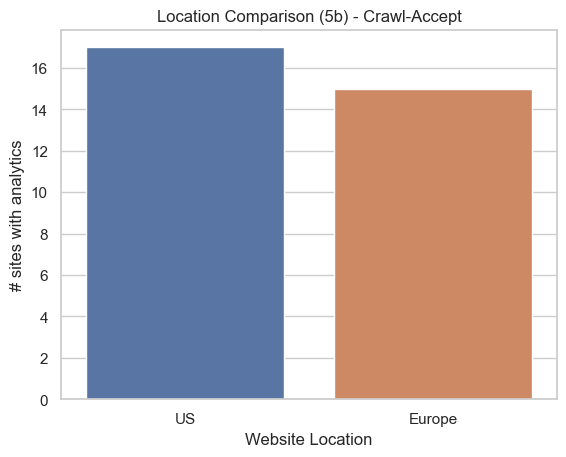

In [8]:
# 5b: Compare US vs European sites with at least one Analytics request in Crawl-Accept

visits_accept, requests_accept = load_results(RESULTS_PATH)

us_countries = {"US"}
eu_countries = {"DE", "FR", "NL", "BE", "ES", "IT", "PT", "SE", "DK", "NO", "FI", "IE", "AT", "CH"}

accept_only = visits_accept[visits_accept["crawl_mode"] == "accept"].copy()
accept_only["region"] = accept_only["country"].str.upper().map(
    lambda c: "US" if c in us_countries else ("Europe" if c in eu_countries else None)
)

analytics_visits_accept = (
    requests_accept[
        (requests_accept["crawl_mode"] == "accept")
        & (requests_accept["disconnect_category"] == "Analytics")
    ]["visit_id"]
    .dropna()
    .unique()
)

summary_5b = (
    accept_only.assign(has_analytics=accept_only["visit_id"].isin(analytics_visits_accept))
    .dropna(subset=["region"])
    .groupby("region")["has_analytics"]
    .sum()
    .reindex(["US", "Europe"])
    .rename("# sites with analytics")
)

# Convert Series into a DataFrame for seaborn
summary_5b_df = (
    summary_5b
    .reset_index()
    .rename(columns={"region": "Region", "# sites with analytics": "Sites with analytics"})
)

sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=summary_5b_df,
    x="Region",
    y="Sites with analytics",
    hue="Region",
    palette=["#4C72B0", "#DD8452"],
    legend=False,
)

ax.set_xlabel("Website Location")
ax.set_ylabel("# sites with analytics")
ax.set_title("Location Comparison (5b) - Crawl-Accept")
plt.show()

This chart compares US and European news websites in the Accept crawl, focusing on the number of sites that sent at least one request to a domain categorized as Analytics in Disconnect's blocklist. US news website have a slightly higher presence of analytics activity, around 17 sites contacting analytics services. European websites follow closely behind, with about 15 sites.

In [9]:
# 6 Extract client-side cookie writes (document.cookie) from Crawl-Accept logs

# Load the cookie write logs captured during the Accept crawl.
COOKIE_LOG_DIR = (pathlib.Path.cwd() / ".." / "crawl_data_accept").resolve()

if not COOKIE_LOG_DIR.exists():
    raise FileNotFoundError(f"No cookie log directory at {COOKIE_LOG_DIR}")

# Parse each document.cookie assignment to recover the cookie name and optional domain.
def parse_cookie_assignment(value: str) -> tuple[str | None, str | None]:
    parts = [part.strip() for part in value.split(";")]
    if not parts or "=" not in parts[0]:
        return None, None
    name = parts[0].split("=", 1)[0].strip() or None
    domain_attr = None
    for part in parts[1:]:
        if part.lower().startswith("domain="):
            domain_attr = part.split("=", 1)[1].strip() or None
            break
    return name, domain_attr

client_cookie_rows: list[dict[str, str]] = []

# Traverse every cookie log, extract the assignments, and store normalized rows.
for path in COOKIE_LOG_DIR.glob("*_cookie_writes.json"):
    data = json.loads(path.read_text(encoding="utf-8"))
    site_host = data.get("domain") or path.stem.removesuffix("_cookie_writes")
    # Method: use the instrumented document.cookie records captured during the Accept crawl.
    for entry in data.get("writes", []):
        if not isinstance(entry, dict) or not isinstance(entry.get("value"), str):
            continue
        name, domain_attr = parse_cookie_assignment(entry["value"])
        if not name:
            continue
        client_cookie_rows.append(
            {
                "Cookie name": name,
                "Website": site_host,
                "Cookie domain": domain_attr or site_host,
            }
        )

client_cookie_df = pd.DataFrame(
    client_cookie_rows,
    columns=["Cookie name", "Website", "Cookie domain"],
).drop_duplicates()

if not client_cookie_df.empty:
    client_cookie_df = client_cookie_df.sort_values(["Website", "Cookie name"]).reset_index(drop=True)

client_cookie_df

,Cookie name,Website,Cookie domain
0,_ga,ad.nl,ad.nl
1,_ga_DN0P5D59BT,ad.nl,ad.nl
2,_gcl_au,ad.nl,ad.nl
3,_gd1763205363591_sharedId,ad.nl,www.ad.nl
4,_gd1763205363591_sharedId,ad.nl,ad.nl
...,...,...,...
1513,rpisb,washingtonpost.com,.www.washingtonpost.com
1514,rpisb,washingtonpost.com,.washingtonpost.com
1515,wp_ptads,washingtonpost.com,.washingtonpost.com
1516,wp_s,washingtonpost.com,.washingtonpost.com


This table lists all cookies written through the Javascript document.cookie API during the Accept crawl. Across all sites, the crawl produced 1518 client-side cookies writes, showing that many websites use Javascript to create or modify cookies after the page loads. These include a mix of analytics, advertising, tracking and preference cookies.

In [10]:
# 7: Top 10 third-party domains per crawl mode

from urllib.parse import urlparse

visits_df, requests_df = load_results(RESULTS_PATH)

# Method: derive third-party hosts from request URLs and aggregate distinct websites per crawl mode.
third_party = requests_df[requests_df["is_third_party"].fillna(False)].copy()
third_party["hostname"] = third_party["url"].map(
    lambda u: urlparse(u).hostname if isinstance(u, str) else None
)
third_party = third_party.dropna(subset=["hostname", "visit_id", "crawl_mode"])

label_map = {
    "accept": "Crawl-Accept",
    "reject": "Crawl-Reject",
    "block": "Crawl-Block"
}

tables: dict[str, pd.DataFrame] = {}

for mode, label in label_map.items():
    subset = third_party[third_party["crawl_mode"] == mode]

    grouped = (
        subset.groupby("hostname")
        .agg(
            distinct_websites=("visit_id", pd.Series.nunique),
            disconnect_categories=(
                "disconnect_category",
                lambda cats: ", ".join(sorted({c for c in cats if c})) or "NA"
            ),
        )
        .reset_index()
        .rename(
            columns={
                "hostname": "Third-party domain",
                "distinct_websites": "Number of distinct websites",
                "disconnect_categories": "Disconnect categories",
            }
        )
        .sort_values("Number of distinct websites", ascending=False)
        .head(10)
        .reset_index(drop=True)  
    )

    tables[label] = grouped

    # Pretty display
    print(f"\nTop 10 third-party domains: {label}")
    display(grouped)


Top 10 third-party domains: Crawl-Accept


,Third-party domain,Number of distinct websites,Disconnect categories
0,pagead2.googlesyndication.com,34,FingerprintingGeneral
1,ep1.adtrafficquality.google,33,Advertising
2,ep2.adtrafficquality.google,33,Advertising
3,ib.adnxs.com,32,Advertising
4,cm.g.doubleclick.net,32,FingerprintingGeneral
5,www.google.com,32,Social
6,securepubads.g.doubleclick.net,31,FingerprintingGeneral
7,match.adsrvr.org,29,FingerprintingGeneral
8,dpm.demdex.net,29,FingerprintingGeneral
9,dsum-sec.casalemedia.com,28,Advertising



Top 10 third-party domains: Crawl-Reject


,Third-party domain,Number of distinct websites,Disconnect categories
0,www.googletagmanager.com,23,NA
1,pagead2.googlesyndication.com,22,FingerprintingGeneral
2,securepubads.g.doubleclick.net,20,FingerprintingGeneral
3,fonts.googleapis.com,16,Content
4,ep1.adtrafficquality.google,15,Advertising
5,ep2.adtrafficquality.google,15,Advertising
6,config.aps.amazon-adsystem.com,14,Advertising
7,c.amazon-adsystem.com,13,Advertising
8,sb.scorecardresearch.com,13,Analytics
9,fonts.gstatic.com,11,Content



Top 10 third-party domains: Crawl-Block


,Third-party domain,Number of distinct websites,Disconnect categories
0,securepubads.g.doubleclick.net,27,FingerprintingGeneral
1,www.googletagmanager.com,24,NA
2,pagead2.googlesyndication.com,23,FingerprintingGeneral
3,c.amazon-adsystem.com,22,Advertising
4,config.aps.amazon-adsystem.com,19,Advertising
5,aax.amazon-adsystem.com,17,Advertising
6,ib.adnxs.com,17,Advertising
7,www.google.com,16,Social
8,sb.scorecardresearch.com,15,Analytics
9,fonts.googleapis.com,14,Content


This analysis lists the top 10 third-party domains contacted by the largest number of websites in each crawl mode, along with the Disconnect categories associated with each domain.
- In the Accept crawl, third-party activity is dominated by Google and advertising ecosystems, showing intensive use of tracking and fingerprinting services, with websites enabling full tracking when consent is given.
- Under Reject, the number of websites contacting each domain decreases, but still many sites still load some analytics, ad-related, or functional third-party resources, at a reduced scale compared to Accept.
- In the Block crawl, third-party activity is reduced, but ad and tracking domains continue to appear.  

In [11]:
# 8: Top 10 websites by number of distinct third-party domains per crawl

visits_df, _ = load_results(RESULTS_PATH)

label_map = {
    "accept": "Crawl-Accept",
    "reject": "Crawl-Reject",
    "block": "Crawl-Block",
}

metric_col = "unique_domains_third_party"

top10_by_crawl = {}

for crawl_mode, label in label_map.items():
    subset = (
        visits_df[visits_df["crawl_mode"] == crawl_mode]
        .loc[:, ["visit_id", "country", metric_col]]
        .sort_values(metric_col, ascending=False)
        .head(10)
        .rename(
            columns={
                "visit_id": "Website",
                "country": "Country code",
                metric_col: "Number of distinct third-party domains",
            }
        )
        .reset_index(drop=True)
    )

    if subset.empty:
        continue

    top10_by_crawl[label] = subset

    print(f"\nTop 10 websites by distinct third-party domains: {label}")
    display(subset)


Top 10 websites by distinct third-party domains: Crawl-Accept


,Website,Country code,Number of distinct third-party domains
0,nltimes.nl,nl,272
1,apnews.com,us,269
2,huffpost.com,us,260
3,gazzetta.it,it,244
4,dailymail.co.uk,uk,228
5,lefigaro.fr,fr,224
6,newsweek.com,us,221
7,libero.it,it,215
8,buzzfeed.com,us,211
9,corriere.it,it,207



Top 10 websites by distinct third-party domains: Crawl-Reject


,Website,Country code,Number of distinct third-party domains
0,nbcnews.com,us,123
1,nypost.com,us,112
2,nltimes.nl,nl,92
3,newsweek.com,us,86
4,libero.it,it,86
5,apnews.com,us,73
6,corriere.it,it,71
7,businessinsider.com,us,70
8,gazzetta.it,it,53
9,huffpost.com,us,53



Top 10 websites by distinct third-party domains: Crawl-Block


,Website,Country code,Number of distinct third-party domains
0,nypost.com,us,121
1,apnews.com,us,115
2,lemonde.fr,fr,106
3,lefigaro.fr,fr,101
4,msnbc.com,us,100
5,nbcnews.com,us,98
6,businessinsider.com,us,80
7,gazzetta.it,it,79
8,buzzfeed.com,us,73
9,the-sun.com,uk,68


This analysis identifies the 10 websites that contacted the highest number of distinct third-party domains in each crawl mode.
- Under the Accept crawl, the number of third-party domains is very high, with top sites containing more than 200 distinct third-parties.
- When consent is rejected, the number of distinct third-party domains drops substantially, but third-party activity still does not disappear. Many sites load third-party resources essential for functionality or services.
- The Block crawl reduces third-party domains, but reduction is not complete. Certain sites load fewer third-party domains when rejecting consent, but more when blocking.

In [12]:
# 9: Top 10 websites by number of distinct destination server IPs across all crawls

visits_df, requests_df = load_results(RESULTS_PATH)

# Compute unique IPs per website (across all crawls)
ip_counts = (
    requests_df
    .dropna(subset=["ipAddress"])
    .groupby("visit_id")["ipAddress"]
    .nunique()
    .rename("unique_server_ips")
)

base_sites = (
    visits_df
    .loc[:, ["visit_id", "country"]]
    .drop_duplicates(subset=["visit_id"])
)

sites_with_ips = base_sites.merge(ip_counts, on="visit_id", how="left")
sites_with_ips["unique_server_ips"] = (
    sites_with_ips["unique_server_ips"].fillna(0).astype(int)
)

# Rank across all websites
top10_all = (
    sites_with_ips
    .sort_values("unique_server_ips", ascending=False)
    .head(10)
    .rename(
        columns={
            "visit_id": "Website",
            "country": "Country code",
            "unique_server_ips": "Number of distinct destination server IPs",
        }
    )
    .reset_index(drop=True)
)

print("Top 10 websites by distinct destination server IPs across all crawls")
display(top10_all)

Top 10 websites by distinct destination server IPs across all crawls


,Website,Country code,Number of distinct destination server IPs
0,apnews.com,us,296
1,nltimes.nl,nl,295
2,gazzetta.it,it,273
3,nypost.com,us,265
4,libero.it,it,256
5,dailymail.co.uk,uk,256
6,lefigaro.fr,fr,248
7,huffpost.com,us,247
8,buzzfeed.com,us,238
9,corriere.it,it,230


This table lists the websites that contacted the highest number of distinct destination IP address across all three crawls. A high number of IPs typically indicates that a website loads content from a large number of servers. Interestingly, many of the same sites also appear in the top 10 for distinct third-party domains, confirming that high numbers of domains often correspond to large numebers of destination IPs. Both US and European websites appear, showing that external connectivity is not limited to one region.

In [13]:
# 10: Permissions-Policy: top 5 completely disabled permissions per crawl

from collections import defaultdict

visits_df, requests_df = load_results(RESULTS_PATH)

def extract_disabled_permissions(header_value: str) -> set[str]:
    # Parse a Permissions-Policy header and return permissions that are completely disabled
    disabled = set()
    if not isinstance(header_value, str):
        return disabled

    # Typical format: "camera=(), geolocation=(self), microphone=()"
    for directive in header_value.split(","):
        directive = directive.strip()
        if not directive or "=" not in directive:
            continue

        name, rest = directive.split("=", 1)
        name = name.strip()

        open_paren = rest.find("(")
        close_paren = rest.find(")", open_paren + 1)
        if open_paren == -1 or close_paren == -1:
            continue

        inner = rest[open_paren + 1 : close_paren].strip()
        # inner == "" ⇒ feature=()
        if inner == "":
            disabled.add(name)

    return disabled

# permission_sites_by_crawl[crawl_mode][permission] = set of visit_ids
permission_sites_by_crawl: dict[str, dict[str, set[str]]] = defaultdict(
    lambda: defaultdict(set)
)

num_requests_with_perm = 0

for _, row in requests_df.iterrows():
    headers = row.get("response_headers")
    if not isinstance(headers, dict):
        continue

    header_val = headers.get("permissions-policy") or headers.get("Permissions-Policy")
    if not header_val:
        continue

    # If header is a list, join the values
    if isinstance(header_val, list):
        header_val = ", ".join(str(v) for v in header_val)

    num_requests_with_perm += 1

    disabled_perms = extract_disabled_permissions(header_val)
    if not disabled_perms:
        continue

    visit_id = row["visit_id"]
    crawl_mode = row.get("crawl_mode")
    if crawl_mode is None:
        continue

    for perm in disabled_perms:
        permission_sites_by_crawl[crawl_mode][perm].add(visit_id)

print("Requests with a Permissions-Policy header:", num_requests_with_perm)

label_map = {
    "accept": "Crawl-Accept",
    "reject": "Crawl-Reject",
    "block": "Crawl-Block",
}

perm_top5_by_crawl = {}

for crawl_mode, label in label_map.items():
    perm_map = permission_sites_by_crawl.get(crawl_mode, {})
    if not perm_map:
        print(f"\nNo Permissions-Policy data for {label}.")
        continue

    summary_rows = [
        {
            "Permission": perm,
            "Number of websites with perm=()": len(sites),
        }
        for perm, sites in perm_map.items()
    ]

    df = (
        pd.DataFrame(summary_rows)
        .sort_values("Number of websites with perm=()", ascending=False)
        .head(5)
        .reset_index(drop=True)
    )

    perm_top5_by_crawl[label] = df

    print(f"\nTop 5 permissions completely disabled (perm=()): {label}")
    display(df)

Requests with a Permissions-Policy header: 1646

Top 5 permissions completely disabled (perm=()): Crawl-Accept


,Permission,Number of websites with perm=()
0,geolocation,19
1,microphone,19
2,camera,19
3,midi,18
4,xr-spatial-tracking,17



Top 5 permissions completely disabled (perm=()): Crawl-Reject


,Permission,Number of websites with perm=()
0,interest-cohort,10
1,geolocation,9
2,microphone,9
3,midi,9
4,camera,9



Top 5 permissions completely disabled (perm=()): Crawl-Block


,Permission,Number of websites with perm=()
0,microphone,16
1,camera,16
2,geolocation,16
3,interest-cohort,15
4,midi,15


This analysis identifies the top 5 permissions that websites completely disable for all origins.
- In the crawl Accept the most frequently disabled permission relate mainly to high-sensitivity sensors.
- In Reject, disabling interest-cohort suggests that some sites tighten cross-site tracking protections when consent is denied.
- With blocking, the most disabled permissions align closely with those seen in Accept.

In [14]:
# 11: Referrer-Policy: non-default policies observed per crawl, with counts of distinct websites

from collections import defaultdict

visits_df, requests_df = load_results(RESULTS_PATH)

# The current browser default:
DEFAULT_REFERRER_POLICY = "strict-origin-when-cross-origin"

# Only valid, spec-defined Referrer-Policy values:
VALID_POLICIES = {
    "no-referrer",
    "no-referrer-when-downgrade",
    "origin",
    "origin-when-cross-origin",
    "same-origin",
    "strict-origin",
    "unsafe-url",
    "strict-origin-when-cross-origin",
}

def normalize_policy(p):
    if not isinstance(p, str):
        return None
    return p.strip().lower()


# Crawl_mode { policy_value : set(visit_id) }
policies_per_crawl = {
    "accept": defaultdict(set),
    "reject": defaultdict(set),
    "block": defaultdict(set),
}

requests_with_header = 0

# Parse all referrer-policy headers
for _, row in requests_df.iterrows():
    headers = row.get("response_headers")
    if not isinstance(headers, dict):
        continue

    # Header may appear as "referrer-policy" or "Referrer-Policy"
    policy = headers.get("referrer-policy") or headers.get("Referrer-Policy")
    if not policy:
        continue

    # Some servers return a list, join into a single string first
    if isinstance(policy, list):
        policy = ", ".join(policy)

    # If multiple policies are present, browsers use the first valid token.
    # Split on commas and take the first non-empty part.
    first_token = policy.split(",")[0]
    policy = normalize_policy(first_token)
    if not policy:
        continue

    requests_with_header += 1

    # Ignore invalid / unknown values (we only keep spec-defined values)
    if policy not in VALID_POLICIES:
        continue

    # Ignore the default (strict-origin-when-cross-origin)
    if policy == DEFAULT_REFERRER_POLICY:
        continue

    crawl = row.get("crawl_mode")
    visit = row.get("visit_id")

    if crawl in policies_per_crawl and visit:
        policies_per_crawl[crawl][policy].add(visit)



# Build and display output tables for each crawl
for crawl_mode, mapping in policies_per_crawl.items():
    if not mapping:
        print(f"\nNo non-default Referrer-Policy found for crawl: {crawl_mode}")
        continue

    rows = []
    for policy, sites in mapping.items():
        rows.append({
            "Referrer-Policy": policy,
            "Distinct websites using this policy": len(sites),
        })

    df = (
        pd.DataFrame(rows)
        .sort_values("Distinct websites using this policy", ascending=False)
        .reset_index(drop=True)
    )

    print(f"\nNon-default Referrer-Policy values: Crawl-{crawl_mode.capitalize()}:")
    display(df)


Non-default Referrer-Policy values: Crawl-Accept:


,Referrer-Policy,Distinct websites using this policy
0,no-referrer-when-downgrade,26
1,same-origin,9
2,no-referrer,6
3,unsafe-url,3
4,origin,2
5,origin-when-cross-origin,2



Non-default Referrer-Policy values: Crawl-Reject:


,Referrer-Policy,Distinct websites using this policy
0,no-referrer-when-downgrade,9
1,same-origin,7
2,no-referrer,4
3,unsafe-url,3
4,origin-when-cross-origin,1



Non-default Referrer-Policy values: Crawl-Block:


,Referrer-Policy,Distinct websites using this policy
0,no-referrer-when-downgrade,13
1,same-origin,5
2,unsafe-url,3
3,origin,2
4,origin-when-cross-origin,2
5,no-referrer,2


This analysis identifies websites that use a non-default Referrer-Policy value. The browser default is strict-origin-when-cross-origin, so all other values are considered intentional deviations. 
- In crawl Accept, the most common non-default policy is no-referrer-when-downgrade, which is an older, more permissive policy still used by many sites for compability. Other policies appear less frequently, showing that sites apply different referrer strategies depending on analytics or tracking needs.
- In crawl Reject, the distribution is similar, but with fewer sites.
- The Block mode does not lead to major shifts in referrer policy usage. Most websites seem to rely on a fixed referrer configuration rather than adapting based on consent or blocking.

In [15]:
# 12: Accept-CH: top 3 high-entropy client hints requested per crawl

from collections import defaultdict

visits_df, requests_df = load_results(RESULTS_PATH)

# List of high-entropy hints from Chrome documentation
HIGH_ENTROPY_HINTS = {
    "sec-ch-ua-arch",
    "sec-ch-ua-bitness",
    "sec-ch-ua-full-version",
    "sec-ch-ua-full-version-list",
    "sec-ch-ua-mobile",
    "sec-ch-ua-model",
    "sec-ch-ua-platform",
    "sec-ch-ua-platform-version",
    "sec-ch-ua-wow64",
    "sec-ch-ua-form-factor",
}

# Storage: crawl_mode -> { hint : set(visit_ids) }
hints_per_crawl = {
    "accept": defaultdict(set),
    "reject": defaultdict(set),
    "block": defaultdict(set),
}

num_accept_ch_headers = 0

for _, row in requests_df.iterrows():
    headers = row.get("response_headers")
    if not isinstance(headers, dict):
        continue

    accept_ch = headers.get("accept-ch") or headers.get("Accept-CH")
    if not accept_ch:
        continue

    num_accept_ch_headers += 1

    # Some servers send lists → flatten to string
    if isinstance(accept_ch, list):
        accept_ch = ", ".join(accept_ch)

    # Split into individual hints
    hints = [h.strip().lower() for h in accept_ch.split(",")]

    crawl = row.get("crawl_mode")
    visit = row.get("visit_id")

    if not crawl or not visit:
        continue

    for hint in hints:
        if hint in HIGH_ENTROPY_HINTS:
            hints_per_crawl[crawl][hint].add(visit)


print("Requests that included Accept-CH header:", num_accept_ch_headers)

# Display tables per crawl
for crawl_mode, mapping in hints_per_crawl.items():
    if not mapping:
        print(f"\nNo Accept-CH behavior observed for crawl: {crawl_mode}")
        continue

    rows = []
    for hint, sites in mapping.items():
        rows.append({
            "Client Hint": hint,
            "Distinct websites": len(sites),
        })

    df = (
        pd.DataFrame(rows)
        .sort_values("Distinct websites", ascending=False)
        .head(3)
        .reset_index(drop=True)
    )

    print(f"\nTop high-entropy Client Hints: Crawl-{crawl_mode.capitalize()}:")
    display(df)

Requests that included Accept-CH header: 1817

Top high-entropy Client Hints: Crawl-Accept:


,Client Hint,Distinct websites
0,sec-ch-ua-model,36
1,sec-ch-ua-arch,36
2,sec-ch-ua-full-version-list,35



Top high-entropy Client Hints: Crawl-Reject:


,Client Hint,Distinct websites
0,sec-ch-ua-model,24
1,sec-ch-ua-platform-version,22
2,sec-ch-ua-arch,22



Top high-entropy Client Hints: Crawl-Block:


,Client Hint,Distinct websites
0,sec-ch-ua-model,25
1,sec-ch-ua-platform-version,23
2,sec-ch-ua-platform,22


This analysis counts how many websites request high-entropy Client Hints via the Accept-CH response header. High-entropy hints reveal detailed information about the user's device, which can increase fingerprintability. 
Overall, many news websites seek detailed device information and this behavior persists even when consent is denied. Compared to the Accept crawl, Block and Reject reduce hint usage, but do not prevent their use.

In [16]:
# 13: Cross-entity HTTP redirects

import json
from tld import get_fld
import pandas as pd

visits_df, requests_df = load_results(RESULTS_PATH)

# Entity map from Disconnect’s entities.json
with open("entities.json", "r") as f:
    entities_data = json.load(f)["entities"]

domain_to_entity: dict[str, str] = {}

for entity_name, info in entities_data.items():
    for d in info.get("properties", []) + info.get("resources", []):
        try:
            etld1 = get_fld(d, fix_protocol=True)
        except Exception:
            continue
        domain_to_entity[etld1] = entity_name

def get_etld1(url: str | None) -> str | None:
    if not isinstance(url, str):
        return None
    try:
        return get_fld(url, fix_protocol=True)
    except Exception:
        return None

REDIRECT_CODES = {301, 302, 303, 307, 308}

redirects_per_crawl: dict[str, list[dict]] = {"accept": [], "reject": [], "block": []}

for _, row in requests_df.iterrows():
    status = row.get("status")
    if status not in REDIRECT_CODES:
        continue

    src_url = row.get("url")
    tgt_url = row.get("redirect_url")
    crawl   = row.get("crawl_mode")
    visit   = row.get("visit_id")

    if not tgt_url or crawl not in redirects_per_crawl:
        continue

    src_dom = get_etld1(src_url)
    tgt_dom = get_etld1(tgt_url)
    if not src_dom or not tgt_dom:
        continue

    # Both domains must be in Disconnect’s entity list
    if (src_dom not in domain_to_entity) or (tgt_dom not in domain_to_entity):
        continue

    src_entity = domain_to_entity[src_dom]
    tgt_entity = domain_to_entity[tgt_dom]

    # We only keep cross-entity redirects
    if src_entity == tgt_entity:
        continue

    redirects_per_crawl[crawl].append(
        {
            "Source domain": src_dom,
            "Source entity": src_entity,
            "Target domain": tgt_dom,
            "Target entity": tgt_entity,
            "Website": visit,
        }
    )

for crawl_mode, rows in redirects_per_crawl.items():
    print(f"\nCross-entity HTTP redirects: Crawl-{crawl_mode.capitalize()}:")
    if not rows:
        print("(None)")
        continue
    df = pd.DataFrame(rows)
    display(df)


Cross-entity HTTP redirects: Crawl-Accept:


,Source domain,Source entity,Target domain,Target entity,Website
0,doubleclick.net,Google,adnxs.com,Microsoft,ad.nl
1,doubleclick.net,Google,adnxs.com,Microsoft,ad.nl
2,doubleclick.net,Google,criteo.com,Criteo,ad.nl
3,turn.com,Nexxen,criteo.com,Criteo,ad.nl
4,admanmedia.com,AdmanMedia,criteo.com,Criteo,ad.nl
...,...,...,...,...,...
3277,doubleclick.net,Google,pubmatic.com,PubMatic,washingtonpost.com
3278,doubleclick.net,Google,pubmatic.com,PubMatic,washingtonpost.com
3279,adsrvr.org,The Trade Desk,pubmatic.com,PubMatic,washingtonpost.com
3280,openx.net,OpenX,the-ozone-project.com,OzoneProject,washingtonpost.com



Cross-entity HTTP redirects: Crawl-Reject:


,Source domain,Source entity,Target domain,Target entity,Website
0,turn.com,Nexxen,liadm.com,LiveIntent,businessinsider.com
1,rqtrk.eu,RoqAd,liadm.com,LiveIntent,businessinsider.com
2,rezync.com,ZetaGlobal,rlcdn.com,LiveRamp,businessinsider.com
3,rlcdn.com,LiveRamp,adnxs.com,Microsoft,businessinsider.com
4,exelator.com,Nielsen,tncid.app,TheNewCo,corriere.it
5,exelator.com,Nielsen,tncid.app,TheNewCo,gazzetta.it
6,adform.net,Adform,tncid.app,TheNewCo,libero.it
7,doubleclick.net,Google,demdex.net,Adobe,nbcnews.com
8,doubleclick.net,Google,criteo.com,Criteo,nbcnews.com
9,turn.com,Nexxen,criteo.com,Criteo,nbcnews.com



Cross-entity HTTP redirects: Crawl-Block:


,Source domain,Source entity,Target domain,Target entity,Website
0,rlcdn.com,LiveRamp,ml314.com,Bombora,bloomberg.com
1,adsrvr.org,The Trade Desk,ml314.com,Bombora,bloomberg.com
2,eyeota.net,Eyeota,ml314.com,Bombora,bloomberg.com
3,ml314.com,Bombora,eyeota.net,Eyeota,bloomberg.com
4,rlcdn.com,LiveRamp,ml314.com,Bombora,businessinsider.com
5,adsrvr.org,The Trade Desk,permutive.com,Permutive,businessinsider.com
6,adsrvr.org,The Trade Desk,ml314.com,Bombora,businessinsider.com
7,adnxs.com,Microsoft,rubiconproject.com,Magnite,buzzfeed.com
8,rlcdn.com,LiveRamp,doubleclick.net,Google,cnn.com
9,doubleclick.net,Google,permutive.com,Permutive,dailymail.co.uk


Cross-entity redirects occur when a request to a domain owned by one company returns an HTTP redirect (301/302/303/307/308) pointing to a domain owned by a different company.
Using Disconnect's entities.json, we mapped each domain to its own company and then identified redirects where the source entity is different from the target entity. 
- The Accept crawl shows by far the highest number of cross-entity redirects, over 3200. DoubleClick, in particular, is the dominant source of cross-entity redirects across many websites. News websites such as washingtonpost.com, ad.nl, and nypost.com appear frequently as the origin of these redirect chains, indicating the use of complex advertising stacks.
- In the Reject crawl, cross-entity remain common but are significantly reduced.
- The Block crawl shows the lowest number of cross-entity redirects. The redirects that persist often involve entities like LiveRamp, The Trade Desk, Bombora, and TripleLift, which may rely on minimal script redirects that the blocking mode cannot fully prevent.

In [17]:
# 14: Resolving CNAMEs for first-party hosts and matching them to Disconnect categories

def build_disconnect_maps(entities_path, services_path):

    # Entity map
    with open(entities_path, "r") as f:
        entities = json.load(f)["entities"]

    domain_to_entity = {}

    for entity_name, info in entities.items():
        domains = info.get("properties", []) + info.get("resources", [])
        for d in domains:
            try:
                etld1 = get_fld(d, fix_protocol=True)
                domain_to_entity[etld1] = entity_name
            except:
                pass

    # Blocklist categories
    with open(services_path, "r") as f:
        services = json.load(f)["categories"]

    domain_to_categories = {}

    for category, entries in services.items():
        for entry in entries:
            for _, homepages in entry.items():
                for _, domains in homepages.items():
                    for d in domains:
                        try:
                            etld1 = get_fld(d, fix_protocol=True)
                            domain_to_categories.setdefault(etld1, set()).add(category)
                        except:
                            pass

    return domain_to_entity, domain_to_categories

# Resolve CNAMEs and match to Disconnect categories
def resolve_cnames_for_hosts(hosts, domain_to_entity, domain_to_categories):

    resolver = dns.resolver.Resolver()
    rows = []

    for host in hosts:
        if host is None:
            continue

        try:
            answers = resolver.resolve(host, "CNAME")
        except:
            continue  # host has no CNAME

        cname_target = str(answers[0].target).rstrip(".")

        try:
            cname_etld1 = get_fld(cname_target, fix_protocol=True)
        except:
            continue

        # Check if CNAME target is on Disconnect blocklist
        categories = domain_to_categories.get(cname_etld1)
        if not categories:
            continue

        entity = domain_to_entity.get(cname_etld1, "Unknown")

        rows.append({
            "first_party_subdomain": host,
            "cname_record": cname_target,
            "cname_entity": entity,
            "disconnect_categories": ", ".join(sorted(categories)),
        })

    return pd.DataFrame(rows)


visits_df, requests_df = load_results(RESULTS_PATH)

# Build Disconnect maps
domain_to_entity, domain_to_categories = build_disconnect_maps(
    ENTITIES_PATH, BLOCKLIST_PATH
)

# Filter only first-party requests
fp = requests_df[requests_df["is_third_party"] == False].copy()
fp["hostname"] = fp["url"].apply(
    lambda u: urlparse(u).hostname if isinstance(u, str) else None
)

# Generate output tables per crawl mode
tables = {}

for mode, group in fp.groupby("crawl_mode"):
    hosts = sorted(group["hostname"].dropna().unique())
    table = resolve_cnames_for_hosts(
        hosts,
        domain_to_entity,
        domain_to_categories
    )
    tables[mode] = table

    print(f"CNAMEs for first-party hosts: Crawl-{mode.capitalize()}")
    if table.empty:
        print("No hosts with CNAME targets present in the Disconnect categories.")
    else:
        display(table)

CNAMEs for first-party hosts: Crawl-Accept


,first_party_subdomain,cname_record,cname_entity,disconnect_categories
0,aamt.msnbc.com,msnbc.com.ssl.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
1,aamt.nbcnews.com,nbcnews.com.ssl.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
2,c2.newsweek.com,c2-newsweek.tinypass.com,Piano,Analytics
3,cdn.newsweek.com,cdn-newsweek.tinypass.com,Piano,Analytics
4,cmp.cdn.the-sun.com,cdn-259.privacy-mgmt.com,Sourcepoint,ConsentManagers
5,dd.nytimes.com,sslgen-nyt.datadome.co,Datadome,Anti-fraud
6,permutive.businessinsider.com,atcvt1h5rg5p.customer.permutive.app,Permutive,Advertising
7,smetrics.cnn.com,cnn.com.102.122.2o7.net,Adobe,"Advertising, Email, FingerprintingGeneral"
8,smetrics.foxnews.com,foxnews.com.ssl.d1.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
9,sourcepoint.n-tv.de,cdn-1239.privacy-mgmt.com,Sourcepoint,ConsentManagers


CNAMEs for first-party hosts: Crawl-Block


,first_party_subdomain,cname_record,cname_entity,disconnect_categories
0,aamt.msnbc.com,msnbc.com.ssl.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
1,aamt.nbcnews.com,nbcnews.com.ssl.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
2,cmp.cdn.the-sun.com,cdn-259.privacy-mgmt.com,Sourcepoint,ConsentManagers
3,dd.nytimes.com,sslgen-nyt.datadome.co,Datadome,Anti-fraud
4,permutive.businessinsider.com,atcvt1h5rg5p.customer.permutive.app,Permutive,Advertising
5,saa.cbsnews.com,cbsnews.com.ssl.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
6,smetrics.foxnews.com,foxnews.com.ssl.d1.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
7,sourcepoint.n-tv.de,cdn-1239.privacy-mgmt.com,Sourcepoint,ConsentManagers
8,sourcepoint.rtl.de,cdn-1239.privacy-mgmt.com,Sourcepoint,ConsentManagers
9,sourcepointcmp.bloomberg.com,cdn-1425.privacy-mgmt.com,Sourcepoint,ConsentManagers


CNAMEs for first-party hosts: Crawl-Reject


,first_party_subdomain,cname_record,cname_entity,disconnect_categories
0,aamt.nbcnews.com,nbcnews.com.ssl.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
1,c2.newsweek.com,c2-newsweek.tinypass.com,Piano,Analytics
2,cdn.newsweek.com,cdn-newsweek.tinypass.com,Piano,Analytics
3,cmp.cdn.the-sun.com,cdn-259.privacy-mgmt.com,Sourcepoint,ConsentManagers
4,dd.nytimes.com,sslgen-nyt.datadome.co,Datadome,Anti-fraud
5,permutive.businessinsider.com,atcvt1h5rg5p.customer.permutive.app,Permutive,Advertising
6,smetrics.foxnews.com,foxnews.com.ssl.d1.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
7,sourcepoint.n-tv.de,cdn-1239.privacy-mgmt.com,Sourcepoint,ConsentManagers
8,sourcepoint.rtl.de,cdn-1239.privacy-mgmt.com,Sourcepoint,ConsentManagers
9,sourcepointcmp.bloomberg.com,cdn-1425.privacy-mgmt.com,Sourcepoint,ConsentManagers


This analysis inspects first-party subdomains to check whether they resolve, via CNAME records, to domain operated by third-party tracking or advertising companies included in the Disconnect blocklist. If a first-party hostname silently aliases to a third-party tracker, the tracker can disguise itself as part of the site's own domain. Across all three crawls, we observe the same recurring patterns, indicating that the presence of these CNAME mappings does not depend on the stated consent choice. 
Several first-party hostnames resolve via CNAME to third-party domains belonging to entities listed in the Disconnect blocklist. These targets fall under categories such as Advertising, Analytics, FingerprintingGeneral, ConsentManagers and Anti-fraud, indicating strong involment of vendors like Adobe, Sourcepoint, Piano and Permutive. 

15 

 1.  The most challenging part was implementing the reject-cookies workflow, because websites deliberately make rejection harder than acceptance. Many sites hide "Reject all" option behind multiple layers, use different layouts, or only provide individual toggles instead of a single global reject button. Others introduce edge cases such as paywalls, "subscribe and reject" screens, language-dependent buttons, or consent banners embedded inside iframes. Handling these inconsistencies required extensive refactoring, multiple fallback strategies, and special logic for specific platforms. Implementing a reliable rejection flow across all these variation was by far the most complex aspect of the assignment.
 
 2. The most unexpected result in the assignment was that rejecting cookies had only a minimal effect on the amount of tracking that occurrred. This was evident across multiple tasks:
- In 3a and 3b, the number of websites loading advertising or analytics scripts dropped only slightly when moving from Accept to Reject and Block.
- In 12, high-entropy CH, which are strongly related to fingerprinting, were still requested by many websites even after rejecting cookies.
- In 13, several websites even issued cross-entity redirects regardless of the consent choice.

  These results show that rejecting cookies does not completely stop the transmission of tracking-related requests, but mainly prevents trackers from writing persistent identifiers, while leaving most network interactions unchanged. What makes this surprising is the widespread assumption, reinforced by cookie banners themselves, that rejecting cookies meaningfully limits data collections. The "Reject cookies" option often alters only storage, not preventing outbound requests, or fingerprinting attempts that occur as soon as the page loads.
  
  Another interesting and unexpected finding is that European sites generated more total requests, more third-party requests, and contacted more third-party domains than US sites. This is surprising given that EU is covered by GDPR, suggesting that European sites are as just as dependent on tracking ecosystems, and in many cases even more so.